# Portfolio Optimization with TrainSelPy

This notebook demonstrates portfolio optimization using TrainSelPy for asset selection under uncertainty.

## Problem Setup

**Scenario**: Select optimal portfolios from 10 candidate assets balancing:
- Expected return
- Risk (volatility)
- Diversification

We'll compare:
1. **Single-objective**: Maximize expected return
2. **Multi-objective**: Trade-off return vs risk

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from trainselpy.core import train_sel

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

## 1. Generate Synthetic Market Data

In [2]:
n_assets = 10
n_scenarios = 100

# True expected returns
true_returns = np.array([0.05, 0.07, 0.12, 0.08, 0.10, 0.06, 0.09, 0.11, 0.07, 0.08])
volatilities = np.array([0.10, 0.15, 0.25, 0.12, 0.18, 0.08, 0.14, 0.20, 0.11, 0.13])

# Generate correlation matrix
correlation = np.eye(n_assets)
for i in range(n_assets):
    for j in range(i+1, n_assets):
        corr = np.random.uniform(0.1, 0.5)
        correlation[i, j] = correlation[j, i] = corr

# Covariance matrix
D = np.diag(volatilities)
covariance = D @ correlation @ D

# Simulate scenarios
scenarios_returns = np.random.multivariate_normal(true_returns, covariance, n_scenarios)
estimated_returns = np.mean(scenarios_returns, axis=0)
estimated_std = np.std(scenarios_returns, axis=0)

print("Asset Risk-Return Profile:")
print("="*60)
for i in range(n_assets):
    print(f"Asset {i+1}: Return={estimated_returns[i]:.3f}, Volatility={estimated_std[i]:.3f}")

Asset Risk-Return Profile:
Asset 1: Return=0.055, Volatility=0.103
Asset 2: Return=0.049, Volatility=0.146
Asset 3: Return=0.138, Volatility=0.258
Asset 4: Return=0.092, Volatility=0.117
Asset 5: Return=0.100, Volatility=0.190
Asset 6: Return=0.062, Volatility=0.086
Asset 7: Return=0.099, Volatility=0.153
Asset 8: Return=0.103, Volatility=0.198
Asset 9: Return=0.079, Volatility=0.099
Asset 10: Return=0.090, Volatility=0.131


## 2. Visualize Risk-Return Landscape

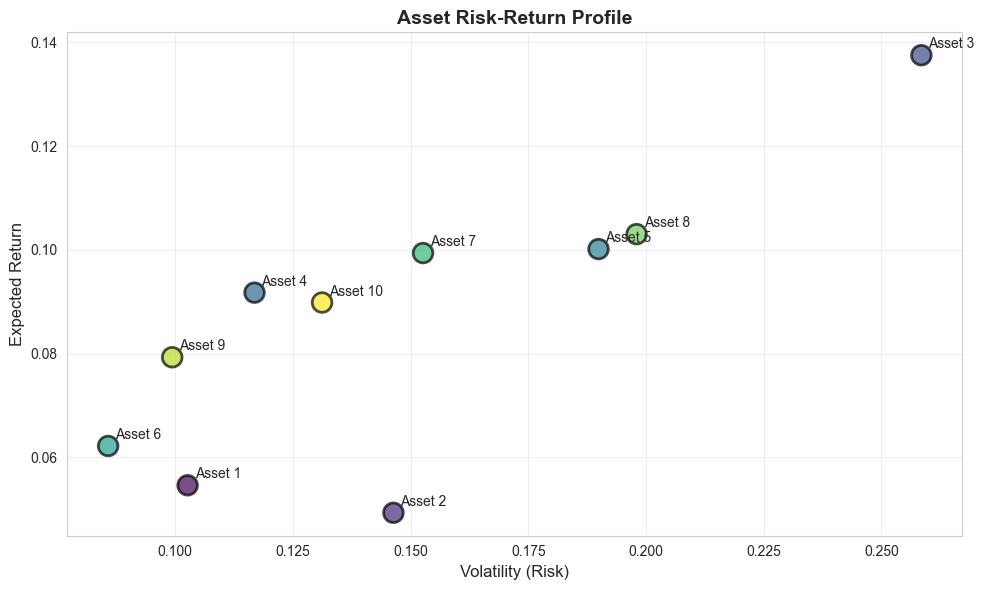

In [3]:
plt.figure(figsize=(10, 6))
plt.scatter(estimated_std, estimated_returns, s=200, c=range(n_assets), cmap='viridis', 
            edgecolors='black', linewidth=2, alpha=0.7)
for i in range(n_assets):
    plt.annotate(f'Asset {i+1}', (estimated_std[i], estimated_returns[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=10)
plt.xlabel('Volatility (Risk)', fontsize=12)
plt.ylabel('Expected Return', fontsize=12)
plt.title('Asset Risk-Return Profile', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Single-Objective: Maximize Expected Return

In [4]:
def portfolio_return(int_vals, data):
    """Expected return of selected assets."""
    selected = int_vals
    returns = data['returns']
    return float(np.mean(returns[selected]))

result_single = train_sel(
    data={'returns': estimated_returns, 'scenarios': scenarios_returns},
    candidates=[list(range(n_assets))],
    setsizes=[5],
    settypes=["UOS"],
    stat=portfolio_return,
    n_stat=1,
    control={"generations": 30, "popsize": 50, "progress": False}
)

selected = result_single.selected_indices[0]
print("Single-Objective Optimization:")
print("="*60)
print(f"Selected Assets: {selected + 1}")
print(f"Expected Return: {np.mean(estimated_returns[selected]):.3f}")
print(f"Portfolio Risk: {np.mean(estimated_std[selected]):.3f}")

Starting TrainSelPy optimization
Optimization completed in 0.24 seconds
Final fitness: 0.1063609834214178
Single-Objective Optimization:
Selected Assets: [3 4 5 7 8]
Expected Return: 0.106
Portfolio Risk: 0.183


## 4. Multi-Objective: Return vs Risk Trade-off

Now let's find a Pareto front of portfolios that balance return and risk.

In [5]:
def portfolio_objectives(int_vals, data):
    """Return two objectives: maximize return, minimize risk."""
    selected = int_vals
    returns = data['returns']
    stds = data['stds']
    
    obj1_return = float(np.mean(returns[selected]))
    obj2_risk = -float(np.mean(stds[selected]))  # Negative to minimize
    
    return [obj1_return, obj2_risk]

result_multi = train_sel(
    data={'returns': estimated_returns, 'stds': estimated_std, 'scenarios': scenarios_returns},
    candidates=[list(range(n_assets))],
    setsizes=[5],
    settypes=["UOS"],
    stat=portfolio_objectives,
    n_stat=2,
    control={"generations": 30, "popsize": 50, "progress": False}
)

print("\nMulti-Objective Optimization:")
print("="*60)
print(f"Pareto Front: {len(result_multi.pareto_front)} solutions")
print(f"\nReturn range: [{min([p[0] for p in result_multi.pareto_front]):.3f}, "
      f"{max([p[0] for p in result_multi.pareto_front]):.3f}]")
print(f"Risk range: [{abs(max([p[1] for p in result_multi.pareto_front])):.3f}, "
      f"{abs(min([p[1] for p in result_multi.pareto_front])):.3f}]")

Starting TrainSelPy optimization
Optimization completed in 2.40 seconds
Final fitness: -0.03166515889888155

Multi-Objective Optimization:
Pareto Front: 22 solutions

Return range: [0.076, 0.106]
Risk range: [0.107, 0.183]


## 5. Visualize Pareto Front

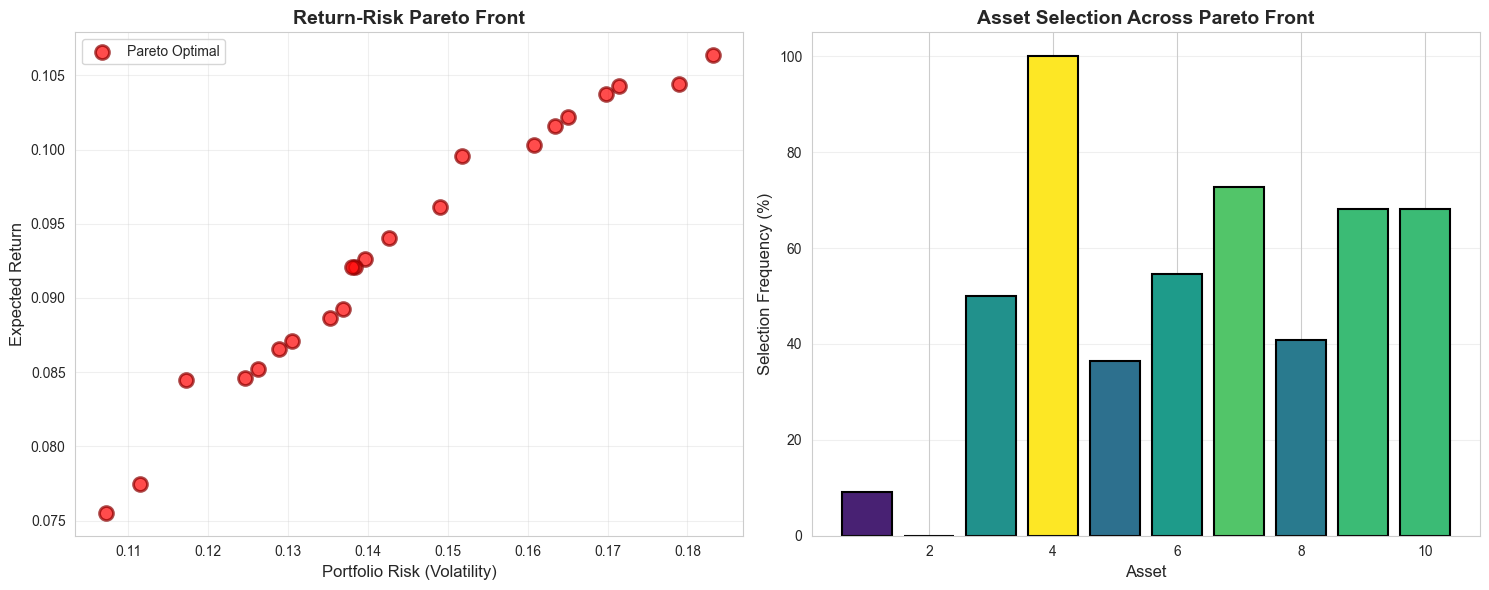


✓ Portfolios optimized successfully!


In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pareto front plot
pf = np.array(result_multi.pareto_front)
ax1.scatter(abs(pf[:, 1]), pf[:, 0], c='red', s=100, alpha=0.7, 
           edgecolors='darkred', linewidth=2, label='Pareto Optimal')
ax1.set_xlabel('Portfolio Risk (Volatility)', fontsize=12)
ax1.set_ylabel('Expected Return', fontsize=12)
ax1.set_title('Return-Risk Pareto Front', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Portfolio composition
asset_freq = np.zeros(n_assets)
for sol in result_multi.pareto_solutions:
    for asset in sol['selected_indices'][0]:
        asset_freq[asset] += 1
asset_freq /= len(result_multi.pareto_solutions)

colors = plt.cm.viridis(asset_freq / asset_freq.max())
bars = ax2.bar(range(1, n_assets+1), asset_freq * 100, color=colors, 
              edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Asset', fontsize=12)
ax2.set_ylabel('Selection Frequency (%)', fontsize=12)
ax2.set_title('Asset Selection Across Pareto Front', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Portfolios optimized successfully!")

## 6. Analyze Trade-offs

Let's examine extreme solutions on the Pareto front.

In [7]:
# Find solutions with max return and min risk
pareto_sorted_return = sorted(result_multi.pareto_solutions, 
                             key=lambda x: x['multi_fitness'][0], reverse=True)
pareto_sorted_risk = sorted(result_multi.pareto_solutions, 
                           key=lambda x: x['multi_fitness'][1], reverse=True)

print("Extreme Portfolios on Pareto Front:")
print("="*60)

# Max return portfolio
max_return_portfolio = pareto_sorted_return[0]['selected_indices'][0]
print(f"\nMax Return Portfolio:")
print(f"  Assets: {max_return_portfolio + 1}")
print(f"  Expected Return: {np.mean(estimated_returns[max_return_portfolio]):.3f}")
print(f"  Portfolio Risk: {np.mean(estimated_std[max_return_portfolio]):.3f}")

# Min risk portfolio
min_risk_portfolio = pareto_sorted_risk[0]['selected_indices'][0]
print(f"\nMin Risk Portfolio:")
print(f"  Assets: {min_risk_portfolio + 1}")
print(f"  Expected Return: {np.mean(estimated_returns[min_risk_portfolio]):.3f}")
print(f"  Portfolio Risk: {np.mean(estimated_std[min_risk_portfolio]):.3f}")

Extreme Portfolios on Pareto Front:

Max Return Portfolio:
  Assets: [3 4 5 7 8]
  Expected Return: 0.106
  Portfolio Risk: 0.183

Min Risk Portfolio:
  Assets: [ 1  4  6  9 10]
  Expected Return: 0.076
  Portfolio Risk: 0.107


## Key Insights

1. **Single-objective** finds the highest-return portfolio but ignores risk
2. **Multi-objective** reveals the return-risk trade-off via Pareto front
3. **Asset frequency** shows which assets appear reliably across trade-offs
4. Investors can **choose from Pareto front** based on risk tolerance

### When to Use Multi-Objective:
- When trade-offs between competing goals exist
- To explore solution space rather than find single "best"
- To understand sensitivity to different preferences